## Machine Learning - Maximum Next Day Weather Temperature with Decision Tree 

The present project consist of the modelling of a weather dataset from the city of Seattle, WA, to
determine its maximum next day temperature using the algorithm of **Decision Tree**.

### Initial Steps

* The libraries `pandas`, `numpy`, `matplotlib`, `seaborn` and `sklearn` were imported;
* The file *temps.csv* was loaded into the notebook. 

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

In [2]:
weather_df = pd.read_csv('temps.csv')
weather_df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
5,2016,1,6,Wed,40,44,46.1,51,43,49,48,40
6,2016,1,7,Thurs,44,51,46.2,45,45,49,46,38
7,2016,1,8,Fri,51,45,46.3,48,43,47,46,34
8,2016,1,9,Sat,45,48,46.4,50,46,50,45,47
9,2016,1,10,Sun,48,50,46.5,52,45,48,48,49


### Dataset Analysis

* The analysis started with an inspection of which types of data were inside each column. It also
had the objective to see if there was missing data. After observation of the values printed by the 
method `describe()`, it was noted that normalization of the data would be necessary in the process
of creating the model.


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
year              348 non-null int64
month             348 non-null int64
day               348 non-null int64
week              348 non-null object
temp_2            348 non-null int64
temp_1            348 non-null int64
average           348 non-null float64
actual            348 non-null int64
forecast_noaa     348 non-null int64
forecast_acc      348 non-null int64
forecast_under    348 non-null int64
friend            348 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [4]:
weather_df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


* It was supposed that the days of the week had an influence in the values of temperature, so the 
conversion of the column *week* to numbers was proposed. However, seeing the problems that bigger
values could have in the decision by the algorithm, a *one-hot encoder* was created to solve this
hindrance. Seven new columns were created, each one with binary values (0,1). 

In [5]:
week_days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
df_1 = weather_df
for day in week_days:
    df_1[day] = weather_df['week']
    for element in df_1['week']:
        if (day == element):
            df_1[day] = df_1[day].replace(element, 1)
        else:
            df_1[day]= df_1[day].replace(element, 0)
df_1.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 19 columns):
year              348 non-null int64
month             348 non-null int64
day               348 non-null int64
week              348 non-null object
temp_2            348 non-null int64
temp_1            348 non-null int64
average           348 non-null float64
actual            348 non-null int64
forecast_noaa     348 non-null int64
forecast_acc      348 non-null int64
forecast_under    348 non-null int64
friend            348 non-null int64
Mon               348 non-null int64
Tues              348 non-null int64
Wed               348 non-null int64
Thurs             348 non-null int64
Fri               348 non-null int64
Sat               348 non-null int64
Sun               348 non-null int64
dtypes: float64(1), int64(17), object(1)
memory usage: 51.8+ KB


In [6]:
df_1[week_days].head()

,Mon,Tues,Wed,Thurs,Fri,Sat,Sun
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0


* To see the correlation between the columns, a **heatmap** was created to see which columns 
had more affinity with one another. The information showed that the columns with temperature values
were more assertive to determine the values of the target column _actual_ than the columns that represented
the days, weeks, months or years.

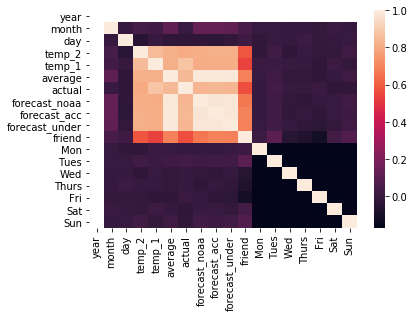

In [7]:
heatmap = sns.heatmap(df_1.corr())
heatmap


* It was created a new column labeled *forecast_avg* to investigate the influence that an average value
would have in the segmentation of the data in the target column *actual*. The row values of the new column
are the mean value of the row values of the columns *forecast_noaa*, *forecast_acc* and *forecast_under*.

In [8]:
df_1['forecast_avg'] = df_1['forecast_acc']
for index in range(0, df_1['forecast_acc'].size):
    df_1['forecast_avg'][index] = (df_1['forecast_noaa'][index] + df_1['forecast_acc'][index] + df_1['forecast_under'][index]) / 3

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* The next step was to use the new column *forecast_avg* to see if there was an improvement in the
segmentation of the data in the column *actual*. The plotting showed that it had indeed some enhancement
in the separation of certain ranges of temperatures. The columns *year* and *month* didn't have a 
good degree of separation, and therefore they were dropped.

/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


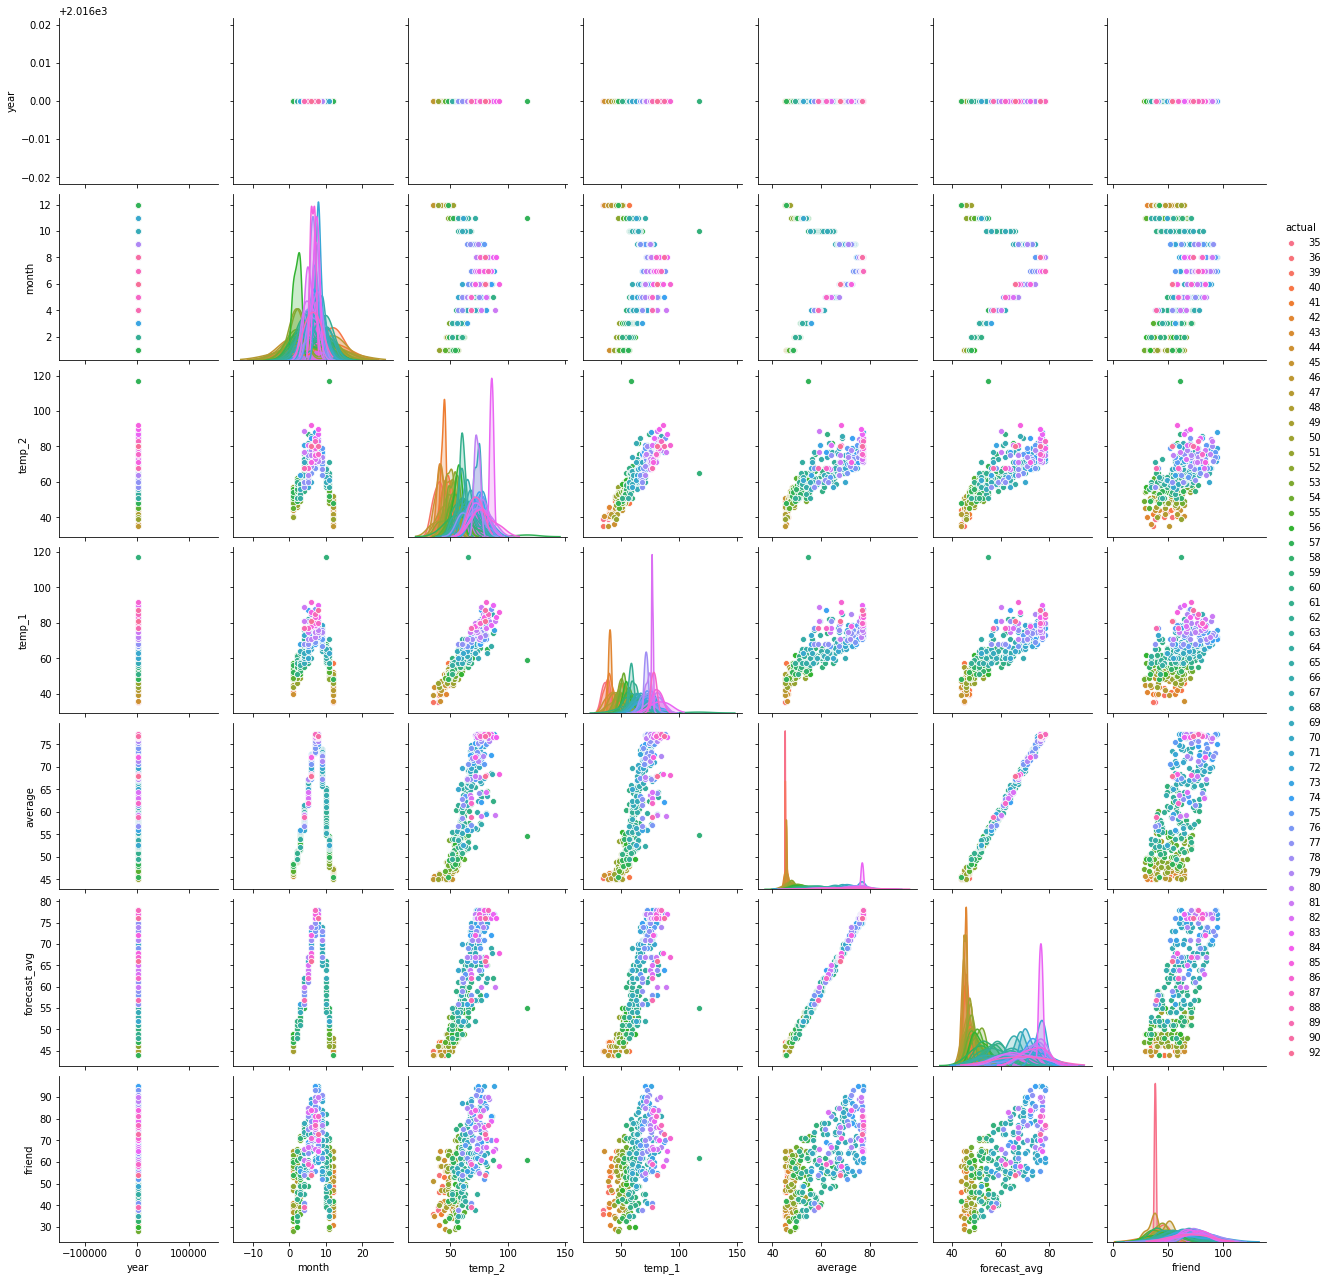

In [9]:
columns = ['year'
        , 'month'
        , 'temp_2'
        , 'temp_1'
        , 'average'
        , 'forecast_avg'
        , 'friend']
target = 'actual'
plot_correlation = sns.pairplot(df_1, vars=columns, hue=target)
plot_correlation

* The columns *forecast_noaa*, *forecast_acc* and *forecast_under* were reintroduced in the array
`columns` to see if there was a better discrimination of data along with the new column *forecast_avg*.
The results show that there is a slightly improvement in the separation with the addition of the column
*forecast_avg*. The column *friend* didn't helped much to separate the values of the column *actual*.  

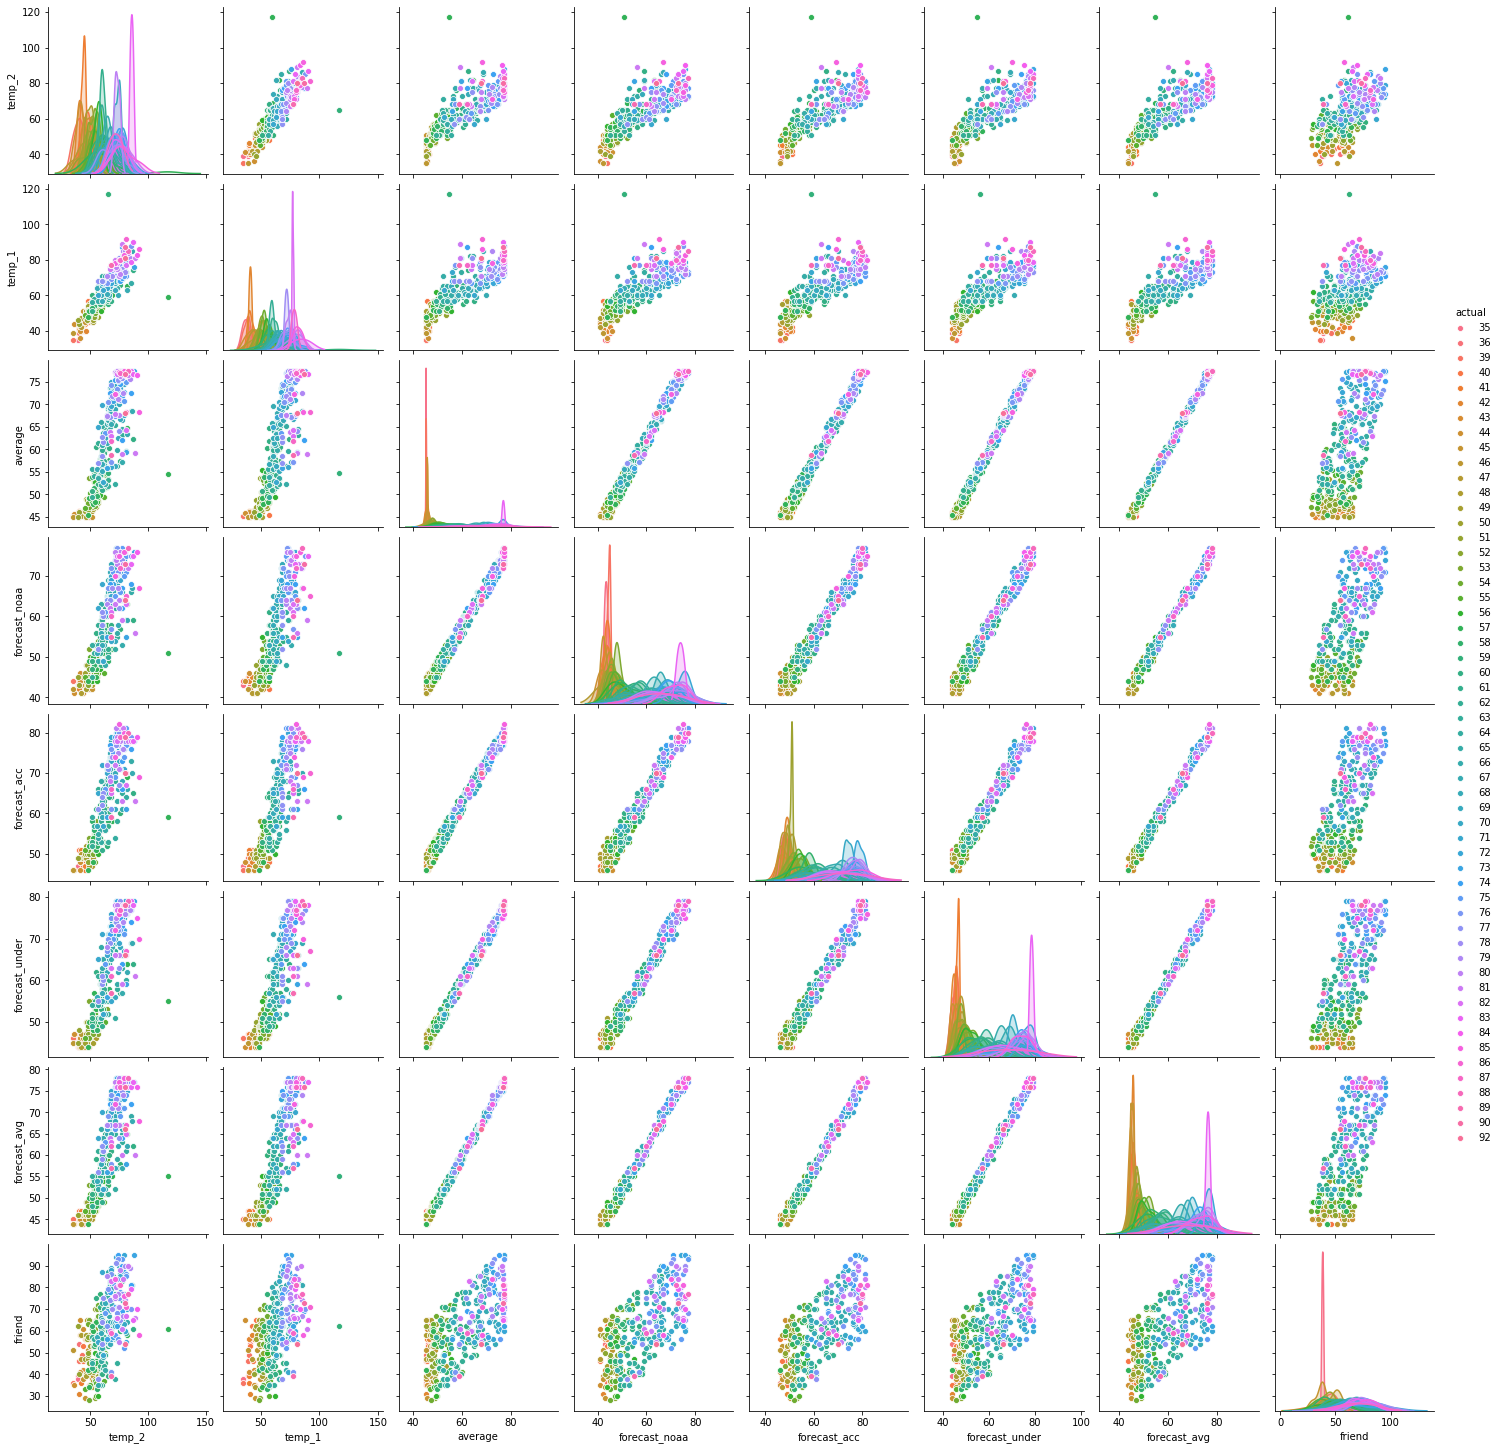

In [10]:
columns = ['temp_2'
        , 'temp_1'
        , 'average'
        , 'forecast_noaa'
        , 'forecast_acc'
        , 'forecast_under'
        , 'forecast_avg'
        , 'friend']
target = 'actual'
plot_correlation = sns.pairplot(df_1, vars=columns, hue=target)
plot_correlation

### Creation of the train an test sets

* When working with temporal series, it is not recommended to split the dataset in a randomic way.
That is because the intention is to foresee the future by looking only to the past data, so the 
splitting must be done with respect to the sequence showed in the dataset. It is utilized the function
`train_test_split()` with the parameter shuffle set to `False` to avoid randomic splits.

In [11]:
X = df_1[['temp_2'
        , 'temp_1'
        , 'average'
        , 'forecast_noaa'
        , 'forecast_acc'
        , 'forecast_under'
        , 'forecast_avg']]
y = df_1['actual']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying cross validation with `TimeSeriesSplit`

* After the normalization of the test set, the objective was to find the best parameters of the chosen decision
tree model, the `DecisionTreeRegressor`. The parameters analyzed were `criterion` and `split`. The values that 
were used as metrics to evaluate the best combination was the mean value (that denotes the accuracy) and the standard
deviation, given by the functions `mean()` and `std()`, both part of `cross_val_score()` function. At the end of execution, the most adequate combination was with
the parameter `criterion` set to *friedman_mse* and the `split` set to *random*, with an accuracy of 0.92 and
standard deviation of 1.60.

In [13]:
tscv = TimeSeriesSplit(n_splits=5)
score = list()
criterion = ['mse', 'friedman_mse', 'mae']
splitter = ['best', 'random']

for crit in criterion:
    for spl in splitter:
        cv_dtr = DecisionTreeRegressor(criterion=crit, splitter=spl)
        cv_score = cross_val_score(cv_dtr, X_train, y_train, cv=tscv)
        score.append([crit, spl, abs(cv_score.mean().round(2)), (cv_score.std() * 2).round(2)]) 
            
for i in score:
    print(i)

['mse', 'best', 1.12, 3.23]
['mse', 'random', 1.01, 2.76]
['friedman_mse', 'best', 1.1, 3.26]
['friedman_mse', 'random', 0.92, 1.6]
['mae', 'best', 0.79, 1.68]
['mae', 'random', 1.06, 1.07]


### Making the Prediction

* Finding the optimal values for `DecisionTreeRegressor`, the next step was to train the model with
the adequate parameters and predict the values using the test set. The accuracy found was low, 0.10.
The conclusion was the model is not so good to predict the maximum next day temperature. A rework of
the dataset may help to increase the quality of the information needed for such prediction. 

In [18]:
dtr_optimal = DecisionTreeRegressor(criterion='friedman_mse', splitter='random')
dtr_optimal.fit(X_train, y_train)
y_pred = dtr_optimal.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        35.0       0.00      0.00      0.00         2
        36.0       0.00      0.00      0.00         1
        39.0       0.00      0.00      0.00         3
        40.0       0.00      0.00      0.00         5
        41.0       0.00      0.00      0.00         2
        42.0       0.00      0.00      0.00         3
        43.0       0.00      0.00      0.00         1
        44.0       0.00      0.00      0.00         2
        45.0       0.00      0.00      0.00         1
        46.0       0.00      0.00      0.00         3
        47.0       0.00      0.00      0.00         1
        48.0       0.25      0.33      0.29         3
        49.0       0.33      0.33      0.33         3
        50.0       0.00      0.00      0.00         2
        51.0       0.00      0.00      0.00         1
        52.0       1.00      0.17      0.29         6
        53.0       0.00      0.00      0.00         1
        54.0       0.00    

### Plotting the Tree

[Text(184.27781492666094, 211.4, 'X[2] <= 0.38\nfriedman_mse = 128.34\nsamples = 243\nvalue = 65.41'),
 Text(95.57374892148404, 199.32, 'X[3] <= -0.46\nfriedman_mse = 93.1\nsamples = 142\nvalue = 59.05'),
 Text(57.256384814495256, 187.24, 'X[6] <= -1.02\nfriedman_mse = 40.46\nsamples = 94\nvalue = 54.51'),
 Text(26.792666091458155, 175.16, 'X[6] <= -1.41\nfriedman_mse = 23.84\nsamples = 50\nvalue = 51.4'),
 Text(13.480586712683348, 163.07999999999998, 'X[2] <= -1.46\nfriedman_mse = 12.91\nsamples = 12\nvalue = 46.08'),
 Text(6.932873166522865, 151.0, 'X[1] <= -1.99\nfriedman_mse = 9.73\nsamples = 9\nvalue = 44.78'),
 Text(3.081276962899051, 138.92000000000002, 'X[4] <= -1.67\nfriedman_mse = 4.0\nsamples = 2\nvalue = 42.0'),
 Text(1.5406384814495255, 126.84, 'friedman_mse = 0.0\nsamples = 1\nvalue = 44.0'),
 Text(4.621915444348577, 126.84, 'friedman_mse = 0.0\nsamples = 1\nvalue = 40.0'),
 Text(10.78446937014668, 138.92000000000002, 'X[5] <= -1.33\nfriedman_mse = 8.53\nsamples = 7\nvalu

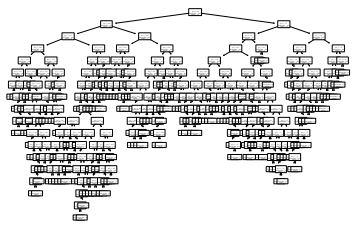

In [19]:
plot_tree(dtr_optimal, rounded=True, precision=2) 

## Model Training Using Random Forests

* The model was trained again this time using the Random Forests algorithm. First, it was executed
a cross validation procedure to determine the optimal configurations. The metrics used were the accuracy
and standard deviation. The best combination produced an accuracy of 0.11, substancialy low in comparison
with that found in the Decision Tree Regressor. Nevertheless, the combination was adopted to train the 
final model.

In [16]:
rf_tscv = TimeSeriesSplit(n_splits=5)
rf_score = list()
rf_score.append(('n_estimators', 'max_depth', 'max_features', 'criterion'))
n_estimators = list(x for x in range(1000) if (x % 100 == 0 and x!= 0))
criterion = ('mse', 'mae')
max_features = ('auto', 'sqrt', 'log2')
max_depth = list(y for y in range(100) if (y % 10 == 0 and y != 0))
best_accuracy = 0
lowest_error = 100

for n_est in n_estimators:
    for max_dp in max_depth:
        for max_ft in max_features:
            for crit in criterion:
                rf_cv = RandomForestRegressor(n_estimators=n_est
                                            , max_depth=max_dp
                                            , max_features=max_ft
                                            , criterion=crit)
                score_cv = cross_val_score(rf_cv, X_train, y_train, cv=rf_tscv)
                if ((abs(score_cv.mean()) > best_accuracy) and ((score_cv.std() * 2) < lowest_error)):
                    best_accuracy = score_cv.mean()
                    lowest_error = score_cv.std() * 2
                    best_combination = list()
                    best_combination.append((n_est, max_dp, max_ft, crit))

print(f'best combination for {rf_score}:')
print('{0}, with accuracy of {1} and standard deviation of {2}'.format(best_combination
                                                                     , best_accuracy.round(2)
                                                                     , lowest_error.round(2)))

best combination for [('n_estimators', 'max_depth', 'max_features', 'criterion')]:
[(100, 60, 'log2', 'mae')], with accuracy of -0.15 and standard deviation of 0.9


# Results

* The accuracy of the model was 0.79, much better than of the Decision Tree. However, with such low
accuracy found in the cross validation method, the result is dubious. By analyzing the accuracy alone,
the conclusion is that the Random Forest algorithm can predict the next day weather better than 
Decision Trees.

In [20]:
rf_opt = RandomForestRegressor(n_estimators=100
                             , max_depth=60
                             , max_features='log2'
                             , criterion='mae')
rf_opt.fit(X_train, y_train)
rf_pred = rf_opt.predict(X_test)
print(f'Accuracy: {rf_opt.score(X_test, y_test):.2f}')


Accuracy: 0.79
